/opt/anaconda3/lib/python3.9/site-packages/scipy/linalg/_matfuncs_sqrtm.py:209: RuntimeWarning: invalid value encountered in scalar divide
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')


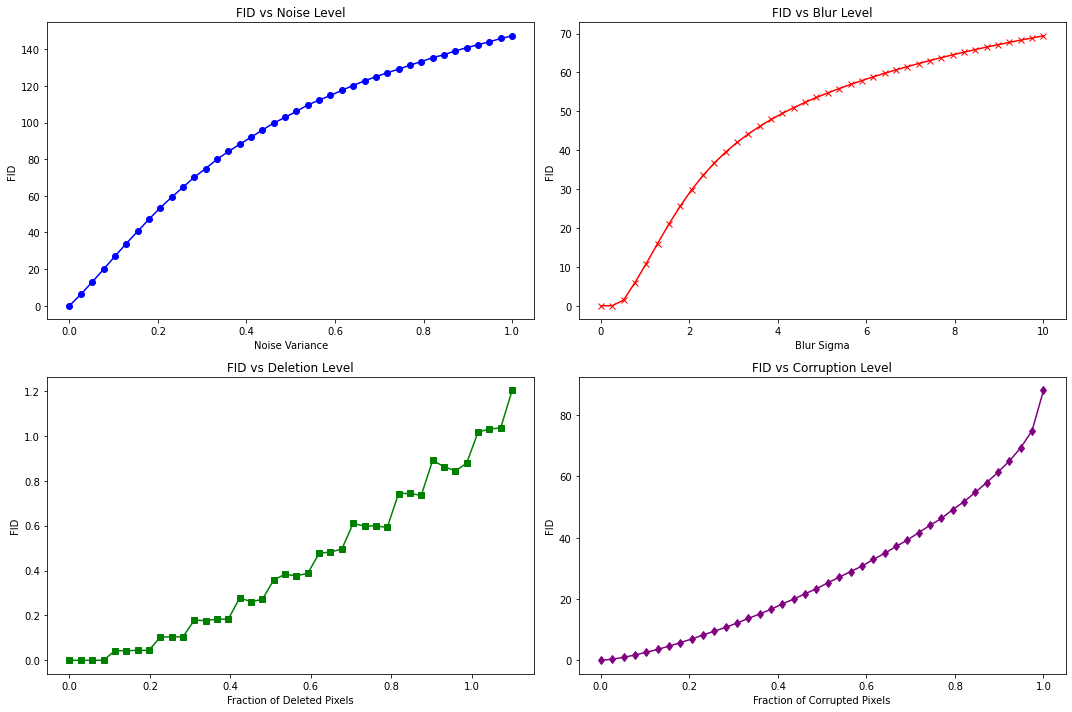

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy.linalg import sqrtm

# Charger la base de données MNIST
(x_train, _), (_, _) = mnist.load_data()

# Normaliser les données
x_train = x_train.astype('float32') / 255.0

# Prendre un sous-échantillon des données pour les tests
n_samples = 3000
x_real = x_train[:n_samples]

# Fonctions de transformation
def add_gaussian_noise(images, var):
    noisy_images = [random_noise(img, mode='gaussian', var=var) for img in images]
    return np.array(noisy_images)

def blur_images(images, sigma):
    blurred_images = [gaussian(img, sigma=sigma) for img in images]
    return np.array(blurred_images)

def corrupt_parts(images, fraction):
    deleted_images = []
    for img in images:
        img_copy = img.copy()
        mask = np.random.rand(*img.shape) < fraction
        img_copy[mask] = 0
        deleted_images.append(img_copy)
    return np.array(deleted_images)

def delete_parts(images, fraction):
    deleted_images = []
    for img in images:
        img_copy = img.copy()
        h, w = img.shape
        num_chunks = int(fraction * (h * w) / (h * w / 10))  # Estimation du nombre de chunks à supprimer
        for _ in range(num_chunks):
            chunk_h = np.random.randint(1, h // 5)  # Hauteur du chunk aléatoire
            chunk_w = np.random.randint(1, w // 5)  # Largeur du chunk aléatoire
            x_start = np.random.randint(0, h - chunk_h)  # Position x de départ
            y_start = np.random.randint(0, w - chunk_w)  # Position y de départ
            img_copy[x_start:x_start + chunk_h, y_start:y_start + chunk_w] = 0
        deleted_images.append(img_copy)
    return np.array(deleted_images)

def calculate_fid(real_images, generated_images):
    # Flatten the images
    real_images_flatten = real_images.reshape((real_images.shape[0], -1))
    generated_images_flatten = generated_images.reshape((generated_images.shape[0], -1))
    
    # Calculate mean and covariance statistics
    mu1, sigma1 = np.mean(real_images_flatten, axis=0), np.cov(real_images_flatten, rowvar=False)
    mu2, sigma2 = np.mean(generated_images_flatten, axis=0), np.cov(generated_images_flatten, rowvar=False)
    
    # Calculate the FID
    diff = mu1 - mu2
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    
    return fid

# Appliquer les transformations et calculer la FID
noise_levels = np.linspace(0, 1, 40)
blur_levels = np.linspace(0, 10, 40)
corrupt_levels = np.linspace(0, 1, 40)
delete_levels = np.linspace(0, 1.1, 40)

fid_noise = []
fid_blur = []
fid_corrupt = []
fid_delete = []

for var in noise_levels:
    noisy_images = add_gaussian_noise(x_real, var)
    fid_noise.append(calculate_fid(x_real, noisy_images))

for sigma in blur_levels:
    blurred_images = blur_images(x_real, sigma)
    fid_blur.append(calculate_fid(x_real, blurred_images))

for fraction in corrupt_levels:
    corrupted_images = corrupt_parts(x_real, fraction)
    fid_corrupt.append(calculate_fid(x_real, corrupted_images))

for fraction in delete_levels:
    deleted_images = delete_parts(x_real, fraction)
    fid_delete.append(calculate_fid(x_real, deleted_images))


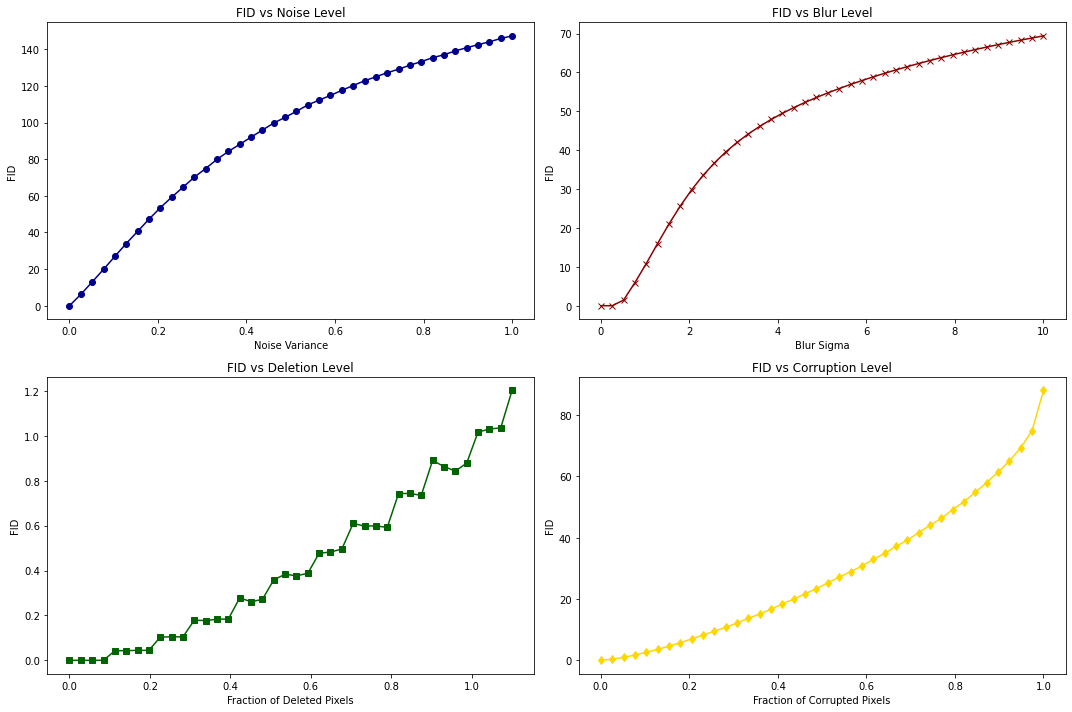

In [13]:

# Plotter la FID en fonction du degré d'intensité
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].plot(noise_levels, fid_noise, marker='o', color='darkblue')
axs[0, 0].set_title('FID vs Noise Level')
axs[0, 0].set_xlabel('Noise Variance')
axs[0, 0].set_ylabel('FID')

axs[0, 1].plot(blur_levels, fid_blur, marker='x', color='darkred')
axs[0, 1].set_title('FID vs Blur Level')
axs[0, 1].set_xlabel('Blur Sigma')
axs[0, 1].set_ylabel('FID')

axs[1, 0].plot(delete_levels, fid_delete, marker='s', color='darkgreen')
axs[1, 0].set_title('FID vs Deletion Level')
axs[1, 0].set_xlabel('Fraction of Deleted Pixels')
axs[1, 0].set_ylabel('FID')

axs[1, 1].plot(corrupt_levels, fid_corrupt, marker='d', color='gold')
axs[1, 1].set_title('FID vs Corruption Level')
axs[1, 1].set_xlabel('Fraction of Corrupted Pixels')
axs[1, 1].set_ylabel('FID')

plt.tight_layout()
plt.show()
